In [50]:
import torch 
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%cd ../


/workspace


In [51]:
sys.path.append('/workspace/Two_Stream_PyTorch/project/')
sys.path

['/workspace/Two_Stream_PyTorch/tests',
 '',
 '/usr/lib/python3.9/site-packages',
 '/usr/lib/python39.zip',
 '/usr/lib/python3.9',
 '/usr/lib/python3.9/lib-dynload',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/workspace/Two_Stream_PyTorch/project/',
 '/tmp/tmpj9iz5yyf',
 '/workspace/Two_Stream_PyTorch/project/']

In [52]:
from project.models.pytorchvideo_models import WalkVideoClassificationLightningModule
from pytorch_lightning import Trainer

from IPython.display import clear_output

clear_output()

In [53]:
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

Global seed set to 42


42

In [54]:
from main import get_parameters

opt, unknown = get_parameters()
opt.num_workers = 8
opt.batch_size = 4
opt.gpu_num = 1

opt.version = '0907_1_31'
opt.model = "resnet"
opt.model_depth = 50
opt.model_class_num = 1

opt.clip_duraion = 1
opt.uniform_temporal_subsample_num = 17
opt.version = opt.version + '_' + opt.model + '_depth' + str(opt.model_depth)


In [55]:
from utils.utils import get_ckpt_path

model = WalkVideoClassificationLightningModule(opt)

# get last ckpt path
# ckpt_path = get_ckpt_path(opt)

ckpt_path = '/workspace/Two_Stream_PyTorch/logs/resnet/0907_1_31_resnet_depth50/checkpoints/epoch=66-val_loss=2.19-val_acc_rgb=0.7580-val_acc_flow=0.7443.ckpt'

# model = WalkVideoClassificationLightningModule.load_from_checkpoint(ckpt_path)
# model.load_state_dict(weight)
model = model.load_from_checkpoint(ckpt_path)

# clear_output()
print(ckpt_path)


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


/workspace/Two_Stream_PyTorch/logs/resnet/0907_1_31_resnet_depth50/checkpoints/epoch=66-val_loss=2.19-val_acc_rgb=0.7580-val_acc_flow=0.7443.ckpt


In [56]:
from dataloader.data_loader import WalkDataModule
from pytorch_lightning import loggers as pl_loggers 

# load test dataset 
module = WalkDataModule(opt)
module.setup()
test_data = module.test_dataloader()

# for the tensorboard
tb_logger = pl_loggers.TensorBoardLogger(save_dir="/workspace/Walk_Video_PyTorch/project/tests/logs", name=opt.model, version=opt.version)


In [57]:

trainer = Trainer(
    accelerator="auto",
    devices=1,
    gpus=opt.gpu_num,
    logger=tb_logger,
    max_epochs=1,
    # deterministic=True,
)

trainer.test(dataloaders=module, model=model, ckpt_path=ckpt_path)


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /workspace/Two_Stream_PyTorch/logs/resnet/0907_1_31_resnet_depth50/checkpoints/epoch=66-val_loss=2.19-val_acc_rgb=0.7580-val_acc_flow=0.7443.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/Two_Stream_PyTorch/logs/resnet/0907_1_31_r

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_acc_flow       │    0.8036529421806335     │
│       test_acc_rgb        │    0.7442922592163086     │
│         test_loss         │     2.453233242034912     │
│    test_precision_flow    │    0.6712328791618347     │
│    test_precision_rgb     │     0.611872136592865     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.453233242034912,
  'test_acc_rgb': 0.7442922592163086,
  'test_acc_flow': 0.8036529421806335,
  'test_precision_rgb': 0.611872136592865,
  'test_precision_flow': 0.6712328791618347}]

In [58]:
# get rgb data and lable
input_data = next(iter(test_data))

video_rgb = input_data['video'].detach() # b, c, t, h, w
label = input_data['label'].detach()

In [59]:
input_data["video_name"]

['20210601_ASD_lat_V1-0012.mp4',
 '20200528_DHS_lat_V1-0033.mp4',
 '20210601_ASD_lat_V1-0002.mp4',
 '20200528_DHS_lat_V1-0016.mp4']

In [60]:
# prepare model
model_rgb = model.model_rgb
model_flow = model.model_flow
optical_flow_model = model.optical_flow_model

In [61]:
# get optical flow, shape (b, c, t, h, w)
video_flow = optical_flow_model.process_batch(video_rgb)

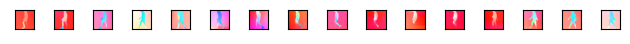

In [62]:
from project.utils.utils import plot
from torchvision.utils import flow_to_image

b, c, f, h, w = video_flow.shape
list_flow_imgs = []

video_flow_plot = video_flow.permute(0, 2, 1, 3, 4) # b, c, f, h, w to b, f, c, h, w

for i in range(f):
    flow_imgs = flow_to_image(video_flow_plot[0][i])
    list_flow_imgs.append(flow_imgs)

len(list_flow_imgs)
plot(list_flow_imgs)

In [63]:
video_rgb.shape, video_flow.shape

(torch.Size([4, 3, 17, 224, 224]), torch.Size([4, 2, 16, 224, 224]))

In [64]:
import numpy as np 

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms


from captum.attr import visualization as viz

model_rgb = model.model_rgb.eval()

torch.manual_seed(123)
np.random.seed(123)

In [65]:
video_rgb = video_rgb.detach()
pred_rgb = model_rgb(video_rgb)
pred_rgb.shape, video_rgb.shape

(torch.Size([4, 1]), torch.Size([4, 3, 17, 224, 224]))

In [66]:
video_rgb[0].unsqueeze(0).shape

torch.Size([1, 3, 17, 224, 224])

In [ ]:
ig = IntegratedGradients(model_rgb)
attributions, delta = ig.attribute(video_rgb[0].unsqueeze(0), target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

In [68]:
attributions.shape, delta

(torch.Size([1, 3, 17, 224, 224]), tensor([0.0588], dtype=torch.float64))

In [69]:
x = attributions.squeeze().cpu().detach().numpy()
x.shape

(3, 17, 224, 224)

In [70]:
y = video_rgb[0].squeeze().cpu().detach().numpy()
y.shape

(3, 17, 224, 224)

In [49]:
x = x.transpose(1, 0, 2, 3)[1].transpose(1, 2, 0)
y = y.transpose(1, 0, 2, 3)[1].transpose(1, 2, 0)

ValueError: axes don't match array

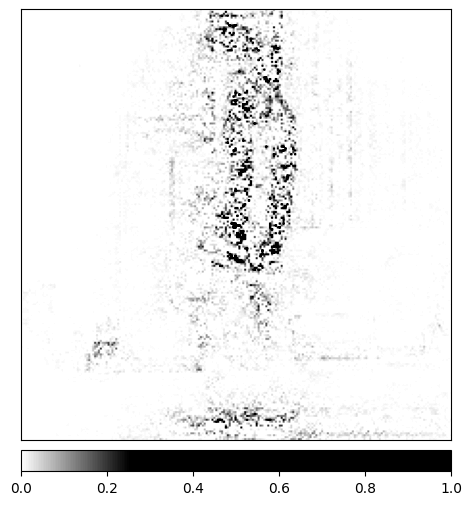

In [48]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(x, y,
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
input_tensor = torch.randn(size=[4, 3, 224, 224])
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=True)